In [1]:
# Importanto bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Carregar dados
arquivo_litecoin = 'D:\Meus Documentos\Documentos\TCC\dataframe\Dados Históricos - Litecoin.csv'
dados_litecoin = pd.read_csv(arquivo_litecoin)

In [3]:
# Convertendo para os tipos de dados corretos
dados_litecoin['Data'] = pd.to_datetime(dados_litecoin['Data'], format="%d.%m.%Y")
dados_litecoin['Último'] = pd.to_numeric(dados_litecoin['Último'].str.replace('.', '').str.replace(',', '.'))
dados_litecoin['Abertura'] = pd.to_numeric(dados_litecoin['Abertura'].str.replace('.', '').str.replace(',', '.'))
dados_litecoin['Máxima'] = pd.to_numeric(dados_litecoin['Máxima'].str.replace('.', '').str.replace(',', '.'))
dados_litecoin['Mínima'] = pd.to_numeric(dados_litecoin['Mínima'].str.replace('.', '').str.replace(',', '.'))

In [4]:
# Tratando valores com K e M
def converter_k_e_m_para_numero(value):
    value = value.replace(',', '.')
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    else:
        return float(value)

dados_litecoin['Vol.'] = dados_litecoin['Vol.'].apply(converter_k_e_m_para_numero)
dados_litecoin['Var%'] = dados_litecoin['Var%'].str.replace(',', '.').str.rstrip('%').astype('float')
dados_litecoin['Var%'].fillna(0, inplace=True)

In [5]:
# Criar um gráfico de candlestick usando a biblioteca plotly

dados_litecoin.set_index('Data', inplace=True)

fig = go.Figure(data=[go.Candlestick(x=dados_litecoin.index,
                open=dados_litecoin['Abertura'],
                high=dados_litecoin['Máxima'],
                low=dados_litecoin['Mínima'],
                close=dados_litecoin['Último'])])

# Adicionar títulos e rótulos aos eixos
fig.update_layout(title='Cotação do Litecoin',
                  xaxis_title='Data',
                  yaxis_title='Preço (USD)')

fig.update_layout(width=1200, height=800)

# Exibir o gráfico
fig.show()

In [6]:
# Dividindo os dados em 80% treinamento e 20% teste
train_df, test_df = train_test_split(dados_litecoin, test_size=0.2, shuffle=False, random_state=42)

In [7]:
# Selecionar as colunas de interesse para a detecção de anomalias
cols_in = ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']

In [8]:
# Definição dos métodos de detecção de anomalias
anomaly_algorithms = {
    "Robust covariance": EllipticEnvelope(),
    "One-Class SVM": svm.OneClassSVM(nu=0.15, kernel="rbf", gamma=0.1),
    "Isolation Forest": IsolationForest(random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, novelty=True),
    "Z-score": stats.zscore
}

In [9]:
# Normalizando os dados
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[cols_in])
test_scaled = scaler.transform(test_df[cols_in])

In [10]:
# Treinamento e aplicação dos algoritmos
results = {}
for name, algorithm in anomaly_algorithms.items():
    if name == "Local Outlier Factor":
        algorithm.fit(train_scaled)
        y_pred = algorithm.predict(test_scaled)
        y_pred = y_pred == -1
    elif name == "Z-score":
        y_pred = [np.abs(stats.zscore(test_scaled[:, i])) > 1.5 for i in range(test_scaled.shape[1])]
        df_zscore = pd.DataFrame(y_pred).T
        y_pred = df_zscore.any(axis=1).values
    else:
        algorithm.fit(train_scaled)
        y_pred = algorithm.predict(test_scaled)
        y_pred = y_pred == -1

    results[name] = y_pred

In [11]:
# Ajustar o tamanho das cores para evitar erros de índice
colors = np.array(["#377eb8", "#ff7f00"])
y_colors = {name: colors[result.astype(int)] for name, result in results.items()}

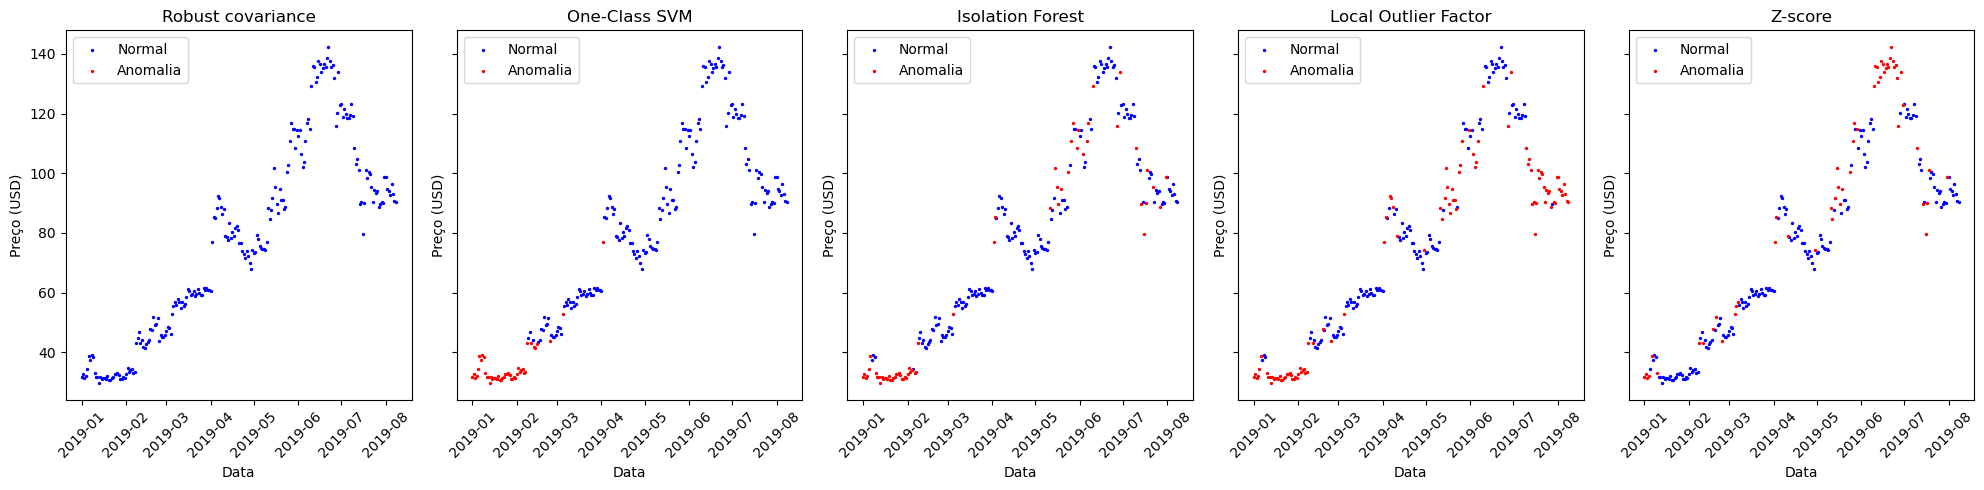

In [12]:
# Visualização dos resultados
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 5))

for i, (name, y_pred) in enumerate(results.items()):
    axs[i].scatter(test_df[~y_pred].index, test_df[~y_pred]['Último'], c='blue', s=2, label='Normal')
    axs[i].scatter(test_df[y_pred].index, test_df[y_pred]['Último'], c='red', s=2, label='Anomalia')
    axs[i].set_title(name)
    axs[i].set_xlabel('Data')
    axs[i].set_ylabel('Preço (USD)')
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# Avaliação dos algoritmos
p_values = {}
p_stats_ = {}
percent = {}
silhouette_scores = {}

for name, y_pred in results.items():
    # Percentual de anomalias
    percent[name] = np.mean(y_pred)

    # Silhouette score para amostras não-anômalas
    labels = [1 if not i else -1 for i in y_pred]
    if len(np.unique(labels)) > 1:
        silhouette_scores[name] = silhouette_samples(test_scaled, labels).mean()
    else:
        silhouette_scores[name] = 0

    # Kolmogorov-Smirnov test
    normal = test_df[~y_pred]
    anomaly = test_df[y_pred]
    for col in cols_in:
        if not normal.empty and not anomaly.empty:  # Check for empty DataFrames
            stats_, pvalue = stats.ks_2samp(normal[col], anomaly[col])
            p_values[f"{col}_{name}"] = pvalue
            p_stats_[f"{col}_{name}"] = stats_

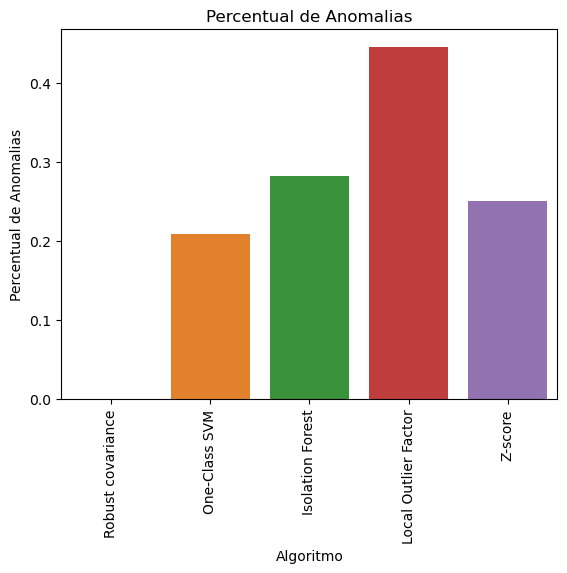

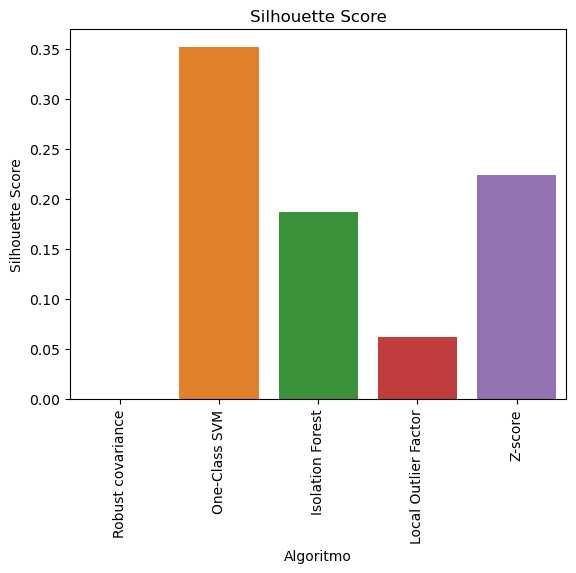

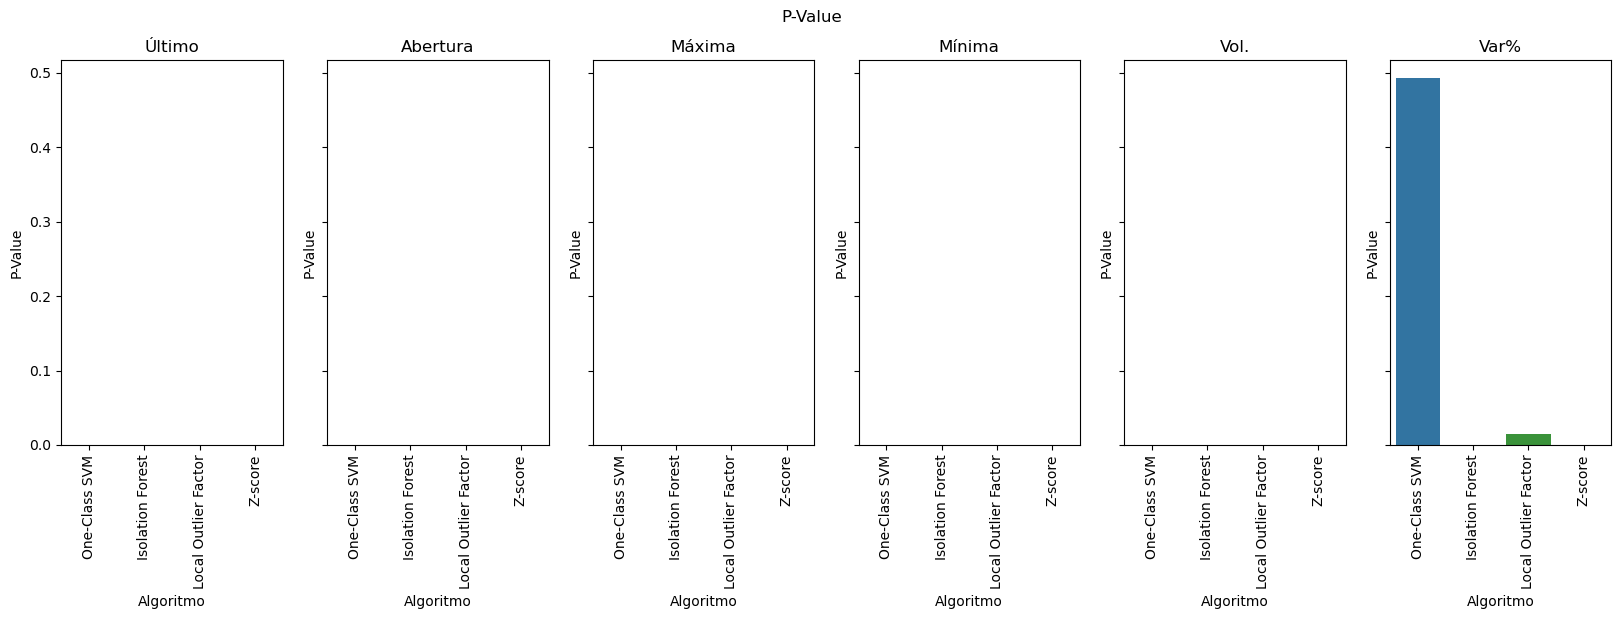

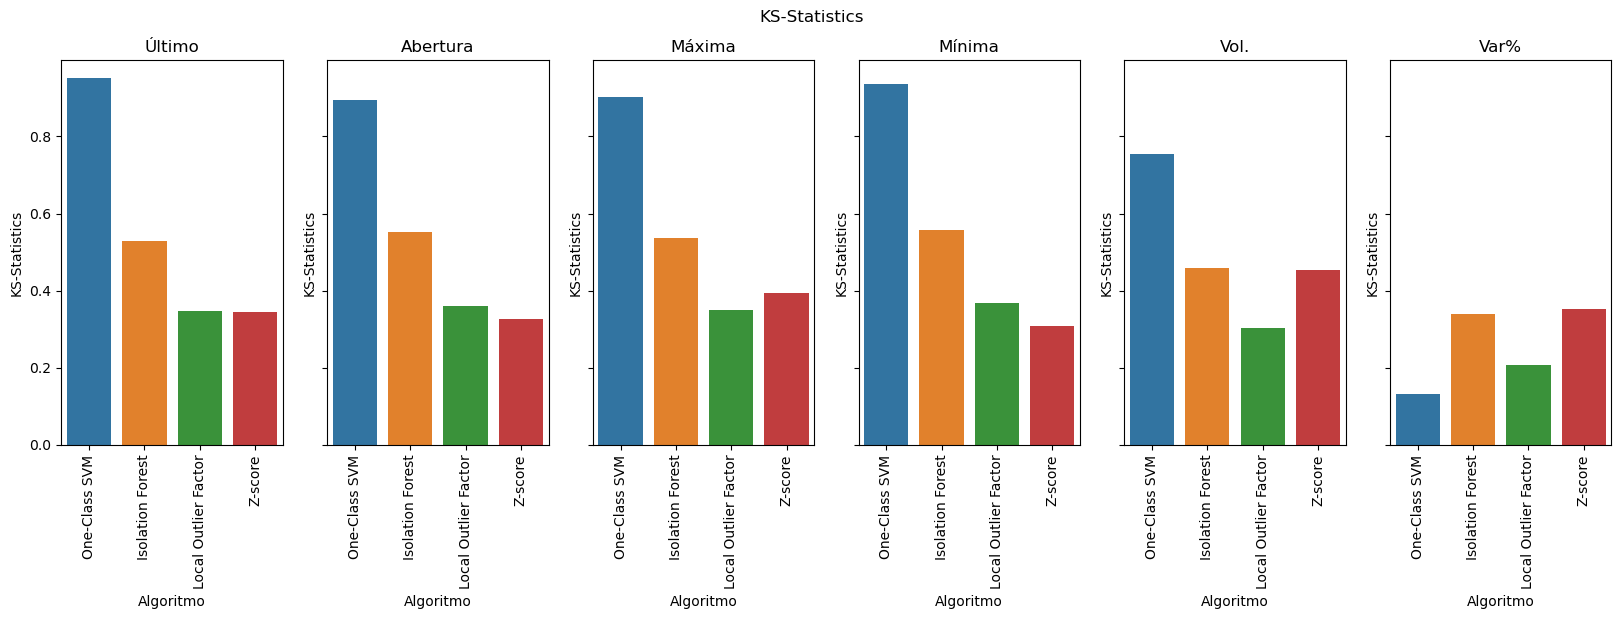

In [14]:
# Visualização das métricas
for metric_name, metric_values in [("Percentual de Anomalias", percent),
                                   ("Silhouette Score", silhouette_scores)]:
    metric_df = pd.DataFrame.from_dict(metric_values, orient='index', columns=[metric_name])
    metric_df = metric_df.reset_index().rename(columns={'index': 'Algoritmo'})
    sns.barplot(data=metric_df, x='Algoritmo', y=metric_name)
    plt.title(metric_name)
    plt.xlabel('Algoritmo')
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    plt.show()

for metric_name, metric_values in [("P-Value", p_values), ("KS-Statistics", p_stats_)]:
    metric_df = pd.DataFrame.from_dict(metric_values, orient='index', columns=[metric_name])
    metric_df = metric_df.reset_index().rename(columns={'index': 'Coluna_Algoritmo'})
    metric_df[['Coluna', 'Algoritmo']] = metric_df['Coluna_Algoritmo'].str.split('_', expand=True)
    fig, axs = plt.subplots(1, len(cols_in), sharey=True, figsize=(20, 5))
    fig.suptitle(metric_name)  # Adiciona um título geral à figura
    for i, col in enumerate(cols_in):
        sns.barplot(data=metric_df[metric_df['Coluna'] == col], x='Algoritmo', y=metric_name, ax=axs[i])
        axs[i].set_title(col)
        axs[i].set_xlabel('Algoritmo')  # Adiciona rótulo ao eixo x
        axs[i].set_ylabel(metric_name)  # Adiciona rótulo ao eixo y
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    plt.show()
    plt.close(fig)

In [15]:
# Visualização do gráfico de candlestick com anomalias destacadas
fig = go.Figure(data=[go.Candlestick(x=test_df.index,
                open=test_df['Abertura'],
                high=test_df['Máxima'],
                low=test_df['Mínima'],
                close=test_df['Último'])])

In [16]:
# %%
# Adicionar anomalias
for name, y_pred in results.items():
    anomalias = test_df[y_pred]
    fig.add_trace(go.Scatter(x=anomalias.index, y=anomalias['Último'],
                             mode='markers',
                             name=name,
                             marker=dict(size=5, color='red')))

In [17]:
# Adicionar títulos e rótulos aos eixos
fig.update_layout(
    title='Cotação do Litecoin com Detecção de Anomalias',
    xaxis_title='Data',
    yaxis_title='Preço (USD)',
    width=1200,
    height=800
)

# Exibir o gráfico
fig.show()